In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tlviz.factor_tools import factor_match_score
import xarray as xr


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# div_hexes = ['#7222D3', neutral_color, '#FF780A']
# div_cmap = get_continuous_cmap(div_hexes)


In [4]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:           (bootstrap: 100, replicate: 3, component: 20,
                       ortholog: 5084, clade: 3, samplename: 76)
Coordinates:
  * bootstrap         (bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * replicate         (replicate) object 'A' 'B' 'C'
  * component         (component) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20
  * ortholog          (ortholog) int64 60000001 60000002 ... 60040287 60040292
  * clade             (clade) object 'HLI' 'HLII' 'LLI'
  * samplename        (samplename) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.N...
Data variables:
    componentweights  (bootstrap, replicate, component) float64 ...
    geneweights       (bootstrap, replicate, component, ortholog) float64 ...
    taxonweights      (bootstrap, replicate, component, clade) float64 ...
    sampleweights     (bootstrap, replicate, component, samplename) float64 ...
    sample            (bootstrap, replicate, samplename) object ...

In [23]:
# read in metadata

sample_df = pd.read_csv('../../data/metadata/archive/sample_metadata_merged.csv')

sample_df


,samplename,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [25]:
# pull out clusters hypothesized to relate to iron limitation

pro_c8_sample_df = pro_ds.sel(component=8).sampleweights.to_series().reset_index()
pro_c8_sample_df = pd.merge(pro_c8_sample_df, sample_df, on='samplename', how='left')

pro_c8_sample_df

,bootstrap,replicate,samplename,sampleweights,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.000000,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.000000,Gradients 1,2016,4/22/16 5:40,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,0.341925,Gradients 1,2016,4/24/16 5:37,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.022443,Gradients 1,2016,4/26/16 5:43,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.219431,Gradients 1,2016,4/27/16 5:41,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22795,99,C,G3.UW.NS.UW35_2.7m,0.031626,Gradients 3,2019,4/26/19 5:55,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
22796,99,C,G3.UW.NS.UW37_1.7m,0.243523,Gradients 3,2019,4/20/19 6:12,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
22797,99,C,G3.UW.NS.UW38_1.7m,0.087427,Gradients 3,2019,4/15/19 5:37,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
22798,99,C,G3.UW.NS.UW40_1.7m,0.006337,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


<Axes: xlabel='latitude', ylabel='sampleweights'>

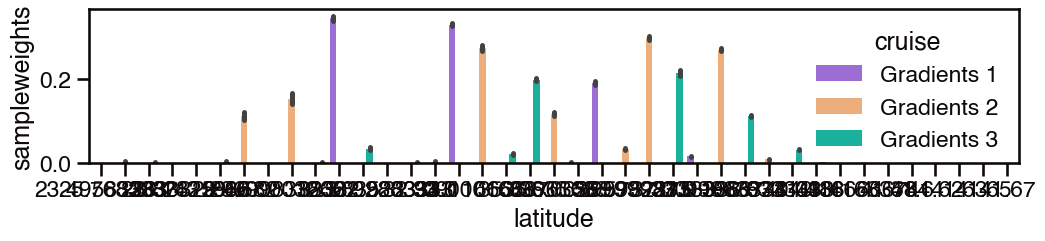

In [27]:
fig, ax = plt.subplots(figsize=(12, 2))

sns.barplot(pro_c8_sample_df, x='latitude', y='sampleweights', hue='cruise', ax=ax)

In [31]:
pro_c8_sample_df[(pro_c8_sample_df.year == 2019) & (pro_c8_sample_df.latitude.gt(41))].groupby('samplename').sampleweights.mean()

samplename
G3.DEPTH.NS.S4C6.15m    3.654468e-05
G3.DEPTH.NS.S4C6.50m    2.102991e-03
G3.DEPTH.NS.S4C6.75m    1.926803e-03
G3.DIEL.NS.S4C11.15m    9.945312e-06
G3.DIEL.NS.S4C13.15m    4.810922e-05
G3.DIEL.NS.S4C15.15m    1.585437e-04
G3.DIEL.NS.S4C18.15m    8.230716e-18
G3.DIEL.NS.S4C19.15m    7.896233e-18
G3.DIEL.NS.S4C21.15m    0.000000e+00
G3.DIEL.NS.S4C25.15m    2.394454e-05
G3.DIEL.NS.S4C3.15m     1.260990e-04
G3.DIEL.NS.S4C30.15m    5.715354e-06
G3.DIEL.NS.S4C31.15m    1.430890e-17
G3.DIEL.NS.S4C4.15m     2.799731e-04
G3.DIEL.NS.S4C7.15m     1.459588e-17
G3.DIEL.NS.S4C8.15m     5.171546e-18
Name: sampleweights, dtype: float64

In [36]:
pro_c8_sample_df[(pro_c8_sample_df.samplename == 'G3.DEPTH.NS.S4C6.15m') & pro_c8_sample_df.sampleweights.gt(0)]

,bootstrap,replicate,samplename,sampleweights,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
880,3,C,G3.DEPTH.NS.S4C6.15m,0.001362,Gradients 3,2019,4/16/19 8:11,41.67,-158.05,15,Gradients 3 depth profile,surface transect,0.34,10am,NaN,NaN,NaN,NaN
12204,53,B,G3.DEPTH.NS.S4C6.15m,0.001290,Gradients 3,2019,4/16/19 8:11,41.67,-158.05,15,Gradients 3 depth profile,surface transect,0.34,10am,NaN,NaN,NaN,NaN
13648,59,C,G3.DEPTH.NS.S4C6.15m,0.000874,Gradients 3,2019,4/16/19 8:11,41.67,-158.05,15,Gradients 3 depth profile,surface transect,0.34,10am,NaN,NaN,NaN,NaN
18132,79,B,G3.DEPTH.NS.S4C6.15m,0.001438,Gradients 3,2019,4/16/19 8:11,41.67,-158.05,15,Gradients 3 depth profile,surface transect,0.34,10am,NaN,NaN,NaN,NaN
21096,92,B,G3.DEPTH.NS.S4C6.15m,0.001347,Gradients 3,2019,4/16/19 8:11,41.67,-158.05,15,Gradients 3 depth profile,surface transect,0.34,10am,NaN,NaN,NaN,NaN
22464,98,B,G3.DEPTH.NS.S4C6.15m,0.000998,Gradients 3,2019,4/16/19 8:11,41.67,-158.05,15,Gradients 3 depth profile,surface transect,0.34,10am,NaN,NaN,NaN,NaN
